# Artificial Intelligence: Project 3
Spencer Hann  
CS 541 | Winter 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
%load_ext cython

In [3]:
%%cython

# cython: boundscheck=False, language_level=3

import numpy as np
cimport numpy as np
import cython
import sys

from tqdm import tqdm
from libc.stdlib cimport rand, RAND_MAX

######################################################################################
##                                                                                  ##
##                              MACROS/MODEL PARAMETERS                             ##
##                                                                                  ##
######################################################################################
DEF DEBUG = 0

DEF world_dim = 10 # world is nxn
DEF num_sensors = 5
DEF num_actions = 5
DEF pick_up_can = 0
DEF north = 1
DEF south = 2
DEF east = 3
DEF west = 4
DEF can = 1
DEF wall = 2
DEF clear = 0
DEF max_state_index = 21211

DEF N = 5000 # episodes
DEF M = 200 # steps per episode

DEF can_reward = +10 # reward for picking up a "can"
DEF wall_reward = -1 # negative reward for crashing into a wall
DEF action_tax = 0

DEF mu = 0.025     # learning rate
DEF gamma = 0.0001  # discount factor

DEF epsilon_init = 1.0
DEF epsilon_final = 0.1
DEF epsilon_decay_rate = 0.01
DEF epsilon_decay_at_epoch = 50

ctypedef unsigned short state # shorts are at least 16 bits, meaning they
                              # support 5 decimal places. the robot has 
                              # 5 sensors, so each decimal place
                              # represents one sensor's reading [0-2]
                              # for a total of 3^5 = 243 possible states,
                              # though not all state are actually possible.
                              # not all sensors can be reading a wall (2)

#################################################################
##                                                             ##
##                       GLOBALS                               ##
##                                                             ##
#################################################################

cdef epsilon = epsilon_init

cdef np.ndarray world

cdef (size_t,size_t) Robby
cdef double[:,::1] Qmatrix = None
IF DEBUG:
    cdef dict action_names = {pick_up_can:"pick up can",
                             north:"move north",
                             south:"move south",
                             east:"move east",
                             west:"move west"}

#########################################################
##                                                     ##
##            INITIALIZATION FUNCTIONS                 ##
##                                                     ##
#########################################################

cdef void init_world():
    global world
    # 50-50 chance of a 1 or zero
    # +2 to make room for walls
    world = np.random.randint(0,2, size=(world_dim+2, world_dim+2), dtype=np.intc)
    # put up walls
    world[:,0] = 2
    world[0,:] = 2
    world[:,-1] = 2
    world[-1,:] = 2
    
cdef void init_Qmatrix():
    global Qmatrix
    Qmatrix = np.zeros((max_state_index+1, num_actions))
    
cdef void init_Robby():
    global Robby
    Robby = tuple(np.random.randint(1, world_dim, size=2, dtype=np.uintp))
    
cdef void init_episode():
#     np.random.seed(42)
    if Qmatrix is None:
        init_Qmatrix()
    init_world()
    init_Robby()

    
########################################################
##                                                    ##
##                 HELPER FUNCTIONS                   ##
##                                                    ##
########################################################

cdef int act(int a):
# executes action a if possible, returns reward (int)
    global Robby
    cdef size_t i,j
    i,j = Robby
    
    if a == pick_up_can:
        if world[i,j] == can:
            world[i,j] = clear
            return can_reward + action_tax
        return action_tax
    
    if a == north:   i -= 1
    elif a == south: i += 1
    elif a == east:  j += 1
    else:            j -= 1
    
    if world[i,j] == wall:
        return wall_reward + action_tax
    
    Robby = i,j
    return action_tax
    
cdef state get_state():
    cdef size_t i,j
    cdef state s
    
    i,j = Robby
    IF DEBUG:
        assert i > 0 and i < world_dim+1, "Robby's lost"
        assert j > 0 and j < world_dim+1, "Robby's lost"

    s = world[i,j] # current
    s += world[i-1,j] * 10**north
    s += world[i+1,j] * 10**south
    s += world[i,j+1] * 10**east
    s += world[i,j-1] * 10**west
    
    IF DEBUG: assert s <= max_state_index
    
    return s

IF DEBUG:
    cdef unsigned int exploration = 0, exploitation = 0
cdef int e_greedy_action(state s):
    cdef int r = rand()
    if r < epsilon:#RAND_MAX * epsilon: # random
        IF DEBUG:
            global exploration
            exploration += 1
        return r % num_actions
    else:
        IF DEBUG:
            global exploitation
            exploitation += 1
        return np.argmax(Qmatrix[s])
    
def display_world():
    cdef int tmp = world[Robby]
    world[Robby] = 8 # because 8 looks like a tiny robot
    print(np.asarray(world))
    world[Robby] = tmp
        
        
###############################################################
##                                                           ##
##                  TRAINING/TESTING                         ##
##                                                           ##
###############################################################
    
cdef int run_episode(int time_steps=M):
    cdef:
        int reward
        int total_reward = 0
        int time_step
        int a
        state s
        state s_prime

    init_episode()
    s_prime = get_state()
    
    for time_step in range(time_steps):
        s = s_prime
        a = e_greedy_action(s)
        IF DEBUG > 2:
            print("\nTime step:",time_step)
            print(Robby, action_names[a])
            display_world()
      
        reward = act(a)
        total_reward += reward
        IF DEBUG > 2: print("rewards:",reward,'/',total_reward)
        
        s_prime = get_state()
        
        Qmatrix[s,a] += mu*(reward + gamma*max(Qmatrix[s_prime]) - Qmatrix[s,a])
    
    return total_reward

def run_epochs(int epochs=N, bint test=False):
    global epsilon
    cdef:
        int epoch
        np.ndarray rewards = np.empty(N,dtype=np.intc)
    IF DEBUG:
        global exploration, exploitation
        exploration = 0
        exploitation = 0
        _iter = range(epochs)
    ELSE: # only use `tqdm` if not printing from inside loop
        _iter = tqdm(range(epochs))
        
    if test: epsilon = epsilon_final
    else: epsilon = epsilon_init
        
    for epoch in _iter:
        if epoch % epsilon_decay_at_epoch == 0:
            if epsilon > epsilon_final: epsilon -= epsilon_decay_rate                

        rewards[epoch] = run_episode()
    
    IF DEBUG: print("Exploration : Exploitation  ",exploration,':',exploitation)
    
    return rewards

## Training phase

In [4]:
%time train_rewards = run_epochs()

100%|██████████| 5000/5000 [00:23<00:00, 215.18it/s]

CPU times: user 24.6 s, sys: 1.83 s, total: 26.4 s
Wall time: 23.2 s


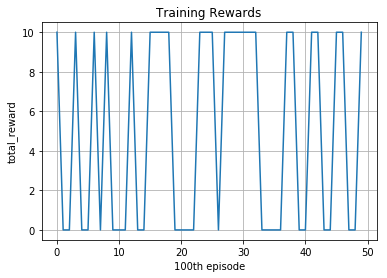

In [5]:
plt.plot(train_rewards[::100])
plt.title("Training Rewards")
plt.xlabel("100th episode")
plt.ylabel("total_reward")
plt.grid()

## Testing phase

In [6]:
%time test_rewards = run_epochs(test=True)

100%|██████████| 5000/5000 [00:24<00:00, 207.56it/s]

CPU times: user 25.4 s, sys: 2 s, total: 27.4 s
Wall time: 24.1 s


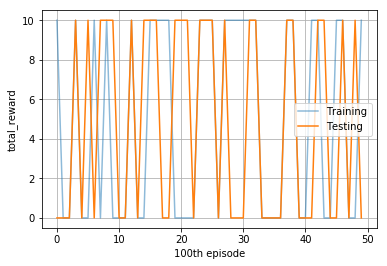

In [7]:
plt.plot(train_rewards[::100], label="Training", alpha=.5)
plt.plot(test_rewards[::100], label="Testing")
plt.legend()
plt.xlabel("100th episode")
plt.ylabel("total_reward")
plt.grid()

Average episode reward: 4.85
Reward std deviation: 5.00


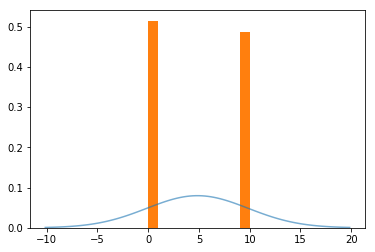

In [8]:
mu = np.mean(test_rewards)
sigma = np.std(test_rewards)

print(f"Average episode reward: {mu:.2f}")
print(f"Reward std deviation: {sigma:.2f}")

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), alpha=.6)
plt.hist(test_rewards, density=True)
plt.show()